# Can we produce value only from order book data?

In this part, with the given limit order book data, we will try to see if there is value in considering only the order book data for a systematic agent in the market.

We will create a typical *bank strategy* for equity markets and try to see if there is the possibility to make profit in that into the intraday power trading market

## The Cross Spread Strategy


This type of strategy consist of:

- An indicator function $I = I(t, O_{t_1}, ..., O_{t-k}, \theta)$
- A Response function $R = R(I, X_t, \phi)$

Where $O_{t_1}, ..., O_{t_k}$ are observables and their lags and $\theta$ is a parameter to be calibrated to makret data. The response function has as arguments the indicator $I,$ the current order status $X_t$ and a calibration parameter $phi$. The response function translates the indicator into a signal. For this strategy, the indicator function will be assimilated by the microprice $\mu_{ab}$ previously discussed, and the response function will be modelled as follows



$$
R_{\mathrm{BUY}} = \left\{
    \begin{array}\\
        \mathrm{cross} \ \mathrm{spread} & \mbox{if } \ \mu_{ab} > P^a - \phi \cdot s_{ab}  \\
        \mathrm{stay} \ \mathrm{posted} & \mbox{if } \ \mu_{ab} \leq P^a - \phi \cdot s_{ab}
    \end{array}
\right.
$$


$$
R_{\mathrm{SELL}} = \left\{
    \begin{array}\\
        \mathrm{cross} \ \mathrm{spread} & \mbox{if } \ \mu_{ab} < P^b + \phi \cdot s_{ab}  \\
        \mathrm{stay} \ \mathrm{posted} & \mbox{if } \ \mu_{ab} \geq P^b + \phi \cdot s_{ab}
    \end{array}
\right.
$$


This type of strategy works very well in a liquid market. We have already seen that in an intraday power market liquidity is higher when an instrument is close to delivery. In the UK intraday market, it can be observed that the last fifteen minutes of each SP instrument are the most liquid. Hence, we will deploy the above strategy on the latter time window.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Analytics.TimeSeriesTools import * 
from Analytics.strategyevaluator import StrategyEvaluator
import scipy.stats as ss
import seaborn as sns
import tqdm



plt.style.use('seaborn')


%load_ext autoreload
%autoreload 2

In [4]:
# Loading Data

raw_quotes = pd.read_pickle('outfile')
quotes = pd.DataFrame(raw_quotes)
quotes.columns = ['delivery_time', 'order_book']
quotes.set_index('delivery_time', drop=True, inplace=True)
quotes.loc['2022-07-28 00:00:00+00:00'].order_book.drop(columns = 'delivery_time', inplace=True)

In [66]:
quotes.loc[delivery_time].order_book

,bid_size,bid,ask,ask_size
time,,,,
2022-07-27 23:07:36,2.4,225.00,NaN,NaN
2022-07-27 23:10:19,5.5,225.00,NaN,NaN
2022-07-27 23:11:07,5.5,225.00,NaN,NaN
2022-07-27 23:13:25,5.5,225.00,268.30,1.0
2022-07-27 23:13:26,4.9,225.02,268.30,1.0
...,...,...,...,...
2022-07-27 23:44:53,6.4,226.00,227.89,2.1
2022-07-27 23:44:54,9.8,227.00,229.98,2.1
2022-07-27 23:44:56,9.8,227.00,229.98,2.1


In [69]:
spreads = []
for delivery_time in deliveries:
    order_book = quotes.loc[delivery_time].order_book.dropna()
    ask = order_book.ask
    bid = order_book.bid
    s = bid_ask_spread(bid, ask)
    
    spreads.append(s)
    

    

<AxesSubplot:xlabel='time'>

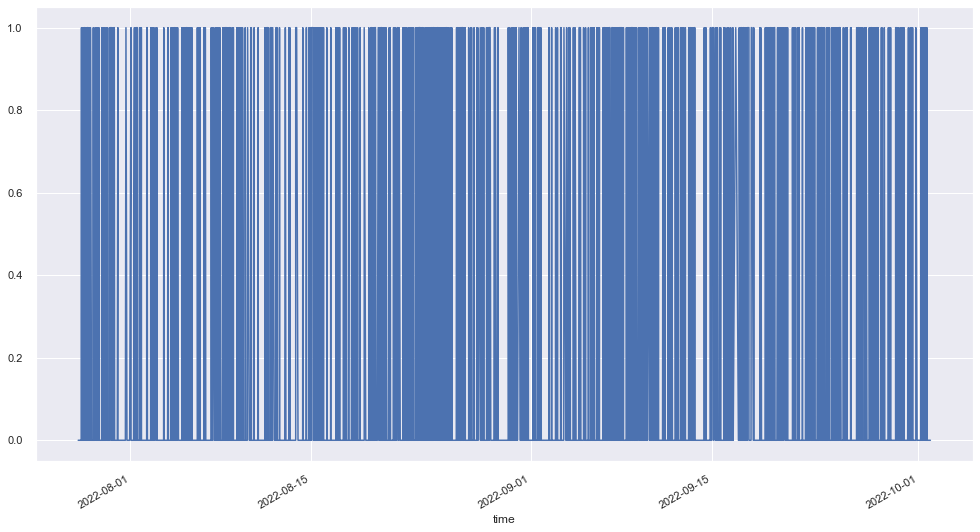

In [79]:
res = pd.concat(spreads, axis=0)
res = res.to_frame('spread')

# res.query('spread<0').shape[0] / res.shape[0]
# res.query("spread<0").eval("spread=spread*(-1)").spread.sort_values().reset_index(drop=True).plot(logy=True)

# (res.query("spread<0").spread < -3).astype(int).plot()

Need to clean up the outfile

In [5]:
# Construct The main functions

def bid_ask_spread(bid: np.array, ask: np.array) -> np.array:
    return ask-bid


def microprice(bid_size: np.array, bid:np.array, ask:np.array, ask_size:np.array) -> np.array:
    I = bid_size / (bid_size + ask_size)
    return ask * I + bid * (1-I)

def lob_imbalance(bid_size: np.array, ask_size: np.array) -> np.array:
    num = bid_size - ask_size
    den = bid_size + ask_size
    return np.round(num/den, 2)
    
def buy_best_ask(order_book: pd.DataFrame, level: int, size: float = 1) -> (float, float, float):
    store_trade = level
    position = 1
    in_position = True
    return store_trade, order_book.ask.iloc[level] * size, position, in_position

def sell_best_bid(order_book: pd.DataFrame, level: int, size: float = 1) -> (float, float, float):
    store_trade = level
    position = -1
    in_position = True
    return store_trade, order_book.bid.iloc[level] * size, position, in_position

def is_good_time(delivery_time:str, timestamp:str, time_to_delivery:float) -> bool:
    time_delta = (pd.to_datetime(delivery_time, utc=True) - pd.to_datetime(timestamp, utc=True)).total_seconds()/60
    return time_delta >= time_to_delivery
    

def is_closing_time(delivery_time: str, timestamp: str, time_to_delivery: float) -> bool:
    time_delta = (pd.to_datetime(delivery_time, utc=True) - pd.to_datetime(timestamp, utc=True)).total_seconds()/60
    return time_delta <= time_to_delivery

def close_position(order_book: pd.DataFrame, position: int, level: int, size: float):
    
    if position == -1:
        store_trade, traded_price, position, in_position = buy_best_ask(order_book, level, size)
        
    elif position == 1:
        store_trade, traded_price, position, in_position = sell_best_bid(order_book, level, size)
        
        
    return store_trade, traded_price, position, in_position    

def is_good_bet(position:int, traded_price:float, lagged_imb:float):
    cash_out = position * (lagged_imb - traded_price)
    return cash_out >= 40
    

## Construction of the algo.

At every delivery time we will have a order book which tracks only the first layer of the order book, namely the market order layer. 

The construction of the algo consist in constructing an event driven backtest. Namely, we will pass into a method representing the algorithm a specific delivery time, for which we retrieve an (historical) order book. Then every layer of the order book will be passed one by one to the logic, exactly as it should be in a real framework.

In [6]:
def cross_spread_algo(delivery_time, phi):
    
   
    order_book = quotes.loc[delivery_time].order_book.dropna()

    position = 0
    trades = 0

    transaction_history = {'delivery_time': [], 'timestamp': [], 'traded_price': [], 'position': []} 


    in_position = False
    

    for layer in range(len(order_book)):

        bid_size = order_book.bid_size.iloc[layer]
        bid = order_book.bid.iloc[layer]
        ask = order_book.ask.iloc[layer]
        ask_size = order_book.ask_size.iloc[layer]

        spread = bid_ask_spread(bid, ask)
        mu = microprice(bid_size, bid, ask, ask_size)

        if not in_position & (is_good_time(delivery_time, order_book.index[layer], time_to_delivery=30.)):

            if mu > ask - phi * spread:
                store_trade, traded_price, position, in_position = buy_best_ask(order_book, level = layer)
                trades +=1
                
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(int(position))


            elif mu < bid + phi * spread:

                store_trade, traded_price, position, in_position = sell_best_bid(order_book, level = layer)
                trades +=1
                
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(int(position))



        elif in_position:

            if not is_closing_time(delivery_time, order_book.index[layer], time_to_delivery = 15.):
                continue

            elif is_closing_time(delivery_time, order_book.index[layer], time_to_delivery = 15.):

                store_trade, traded_price, position, in_position = close_position(order_book, position, level = layer, size=1)
                trades +=1
                
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(int(position))
                break 
                # if break is uncommented then there will be only two trade per SP


                
    trading_session = pd.DataFrame(transaction_history)
    trading_session.set_index('delivery_time', inplace=True, drop=True)    

    return trading_session

In [59]:
deliveries = quotes.index
for i in range(100):
    delivery_time = rnd_delivery_time = np.random.choice(deliveries)


    trial = cross_spread_algo(delivery_time, phi = -0.75)
    sreturns = (trial.traded_price - trial.traded_price.shift(1)) * trial.position.shift(1)
    term = sreturns.sum()
    print('Terminal Wealth: {:.2f}'.format(term))

Terminal Wealth: 0.00
Terminal Wealth: -3.57
Terminal Wealth: 0.00
Terminal Wealth: -24.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: -37.49
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 45.93
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 84.52
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: -10.00
Terminal Wealth: -10.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 2.00
Terminal Wealth: -20.99
Terminal Wealth: 7.48
Terminal Wealth: -16.50
Terminal Wealth: 0.00
Terminal Wealth: 116.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: -56.62
Terminal Wealth: 30.81
Terminal Wealth: -3.50
Terminal Wealth: 0.00
Terminal Wealth: 0.00
Terminal Wealth: -0.37
Terminal Wealth: 0.00
Terminal Wealth: -6.60
Terminal Wealth: 44.32
Terminal

PERFORMANCE METRICS
Terminal Wealth: 1279.5
--------------------------------------------------------------------------------
Sharpe Ratio: 0.01
--------------------------------------------------------------------------------
Sortino Ratio: 0.85
--------------------------------------------------------------------------------
Hit Rate: 0.23
--------------------------------------------------------------------------------
# Trades: 8420 | Wins: 1923.0 | Losses: 6497.0
--------------------------------------------------------------------------------
Average Return: 0.15
--------------------------------------------------------------------------------
Median Return: 0.0
--------------------------------------------------------------------------------
Standard Deviation of Returns: 31.76
--------------------------------------------------------------------------------
HHI: 5.19 | HHI plus: 0.0 | HHI minus: 0.0
--------------------------------------------------------------------------------
Gain-L

<AxesSubplot:title={'center':'Strategy Equity Curve'}, xlabel='delivery_time'>

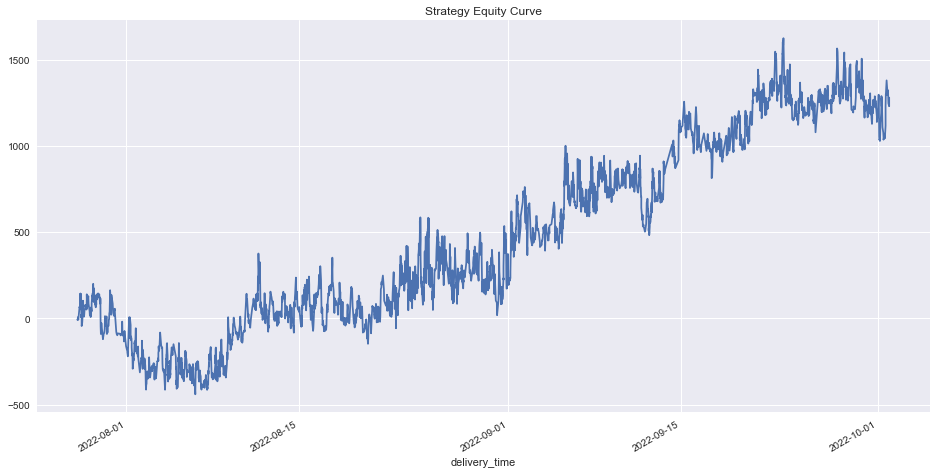

In [60]:
# Apply the algo to the whole dataset

deliveries = quotes.index

all_trading_sessions = []

for delivery_time in deliveries:
    
    trading_session = cross_spread_algo(delivery_time, phi = -0.75)
    all_trading_sessions.append(trading_session)
    
sess1 = pd.concat([all_trading_sessions[k] for k in range(len(all_trading_sessions))], axis=0)

sreturns = (sess1.traded_price - sess1.traded_price.shift(1)) * sess1.position.shift(1)

sev = StrategyEvaluator(data = sreturns, rounding = 2)
sev.print_performance()
sev.plot_performance()

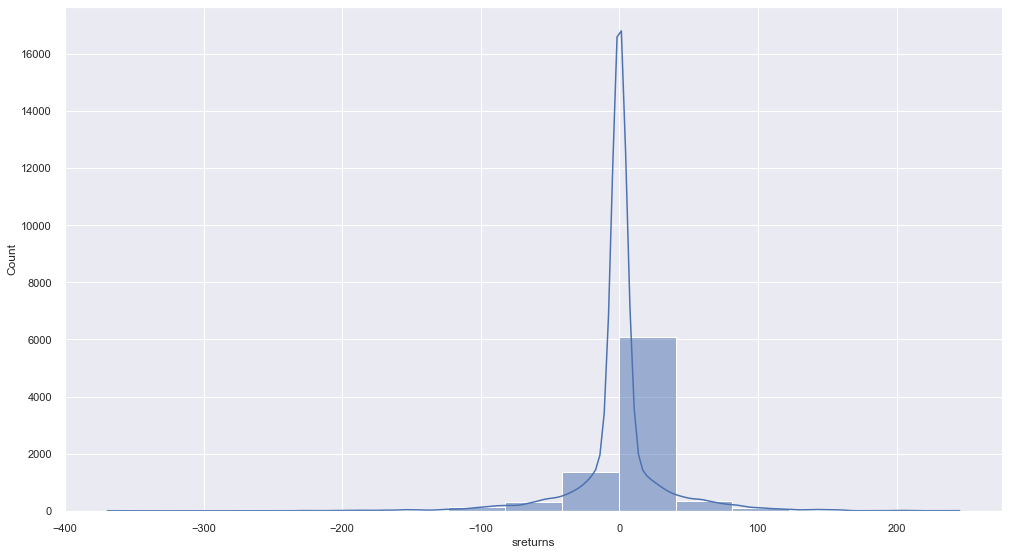

In [61]:
sev.plot_distribution()

PERFORMANCE METRICS
Terminal Wealth: 1279.5
--------------------------------------------------------------------------------
Sharpe Ratio: 0.01
--------------------------------------------------------------------------------
Sortino Ratio: 0.85
--------------------------------------------------------------------------------
Hit Rate: 0.23
--------------------------------------------------------------------------------
# Trades: 8420 | Wins: 1923.0 | Losses: 6497.0
--------------------------------------------------------------------------------
Average Return: 0.15
--------------------------------------------------------------------------------
Median Return: 0.0
--------------------------------------------------------------------------------
Standard Deviation of Returns: 31.76
--------------------------------------------------------------------------------
HHI: 5.19 | HHI plus: 0.0 | HHI minus: 0.0
--------------------------------------------------------------------------------
Gain-L

<AxesSubplot:title={'center':'Strategy Equity Curve'}, xlabel='delivery_time'>

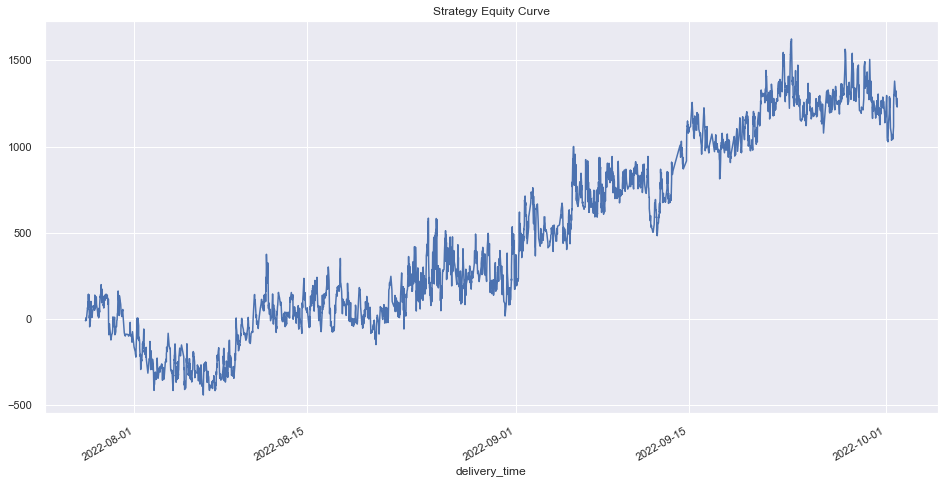

In [7]:
# Negative phi

# Apply the algo to the whole dataset

deliveries = quotes.index

all_trading_sessions = []

for delivery_time in deliveries:
    
    trading_session = cross_spread_algo(delivery_time, phi = -0.5)
    all_trading_sessions.append(trading_session)
    
sess1 = pd.concat([all_trading_sessions[k] for k in range(len(all_trading_sessions))], axis=0)

sreturns = (sess1.traded_price - sess1.traded_price.shift(1)) * sess1.position.shift(1)

sev = StrategyEvaluator(data = sreturns, rounding = 2)
sev.print_performance()
sev.plot_performance()

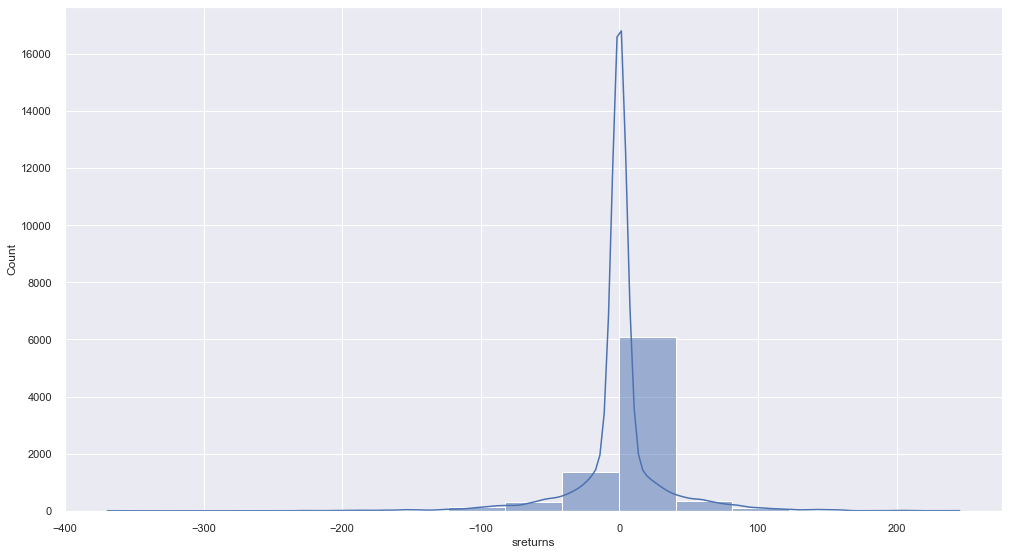

In [8]:
sev.plot_distribution()

## Conclusion

we have chosen $|\phi| = 0.5$ for simplicity. But, other calibration might be better suited for the power market. We can see that when $\phi > 0 $ then the strategy has a great value distruction, whereas for $\phi < 0$ the value tends to increase. The latter case corresponds also to the order reversal of the response function. This suggests that the order book imbalance could potentially be more suited for strategies taking into account only the order book.

## Order Book imbalance

Another strategy is to use the order book imbalance. We recall the definition of order book imbalance as

$$ \rho = \frac{Q^b - Q^a}{Q^b + Q^a} $$

From its definition we can see that $\rho \in [-1,1]$

This indicator explains the disbalance of an order book from a specific order type. When $\rho = 1$ then the order book is totally disbalanced to the bid size, whereas when $\rho = -1$ then the order book is totally disbalanced to the ask size. More formally, A $\rho$-value close to -1 is obtained when market makers post a large volume at the ask relative to the bid volume. A $\rho$-value close to 1 means there is a large volume at the bid side of the order book relative to the ask side. With an imbalance of zero the order book is perfectly balanced at the given level L. The hypothesis suggests that low imbalance numbers (<0) imply negative returns, high imbalance numbers (>0) imply positive returns, i.e., the price moves into the direction of the imbalance ρ.

Assuming $\rho$ as an indicator, that gets computed at every bid and ask, we need to translate it to a response function $R,$ as follows:



$$
R = \left\{
    \begin{array}\\
        R_{\mathrm{BUY}} & \mbox{if } \ \rho >  \phi   \\
        R_{\mathrm{SELL}}  & \mbox{if } \ \rho < \phi 
    \end{array}
\right.
$$

Where $\phi \in (-1,1)$ is a parameter to be calibrated to market data. Also in this case, since the trading strategies that looks at the market microstructure are more suited to more liquid markets, then we will restrict the trading window to the last fifteen minutes of each settlement period.



In [42]:
def orderbook_imbalance_algo(delivery_time, phi_up, phi_down):
    
    order_book = quotes.loc[delivery_time].order_book.dropna()

    position = 0
    trades = 0

    transaction_history = {'delivery_time': [], 'timestamp': [], 'traded_price': [], 'position': []} 


    in_position = False
    

    for layer in range(len(order_book)):

        bid_size = order_book.bid_size.iloc[layer]
        bid = order_book.bid.iloc[layer]
        ask = order_book.ask.iloc[layer]
        ask_size = order_book.ask_size.iloc[layer]
        
        rho = lob_imbalance(bid_size, ask_size)
        
        
        if not in_position & (is_good_time(delivery_time, order_book.index[layer], time_to_delivery=30.)):
            
                
            if rho > phi_up:
                
                store_trade, traded_price, position, in_position = sell_best_bid(order_book, level = layer)
                trades +=1
                
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(int(position))


            elif rho < phi_down:

                store_trade, traded_price, position, in_position = buy_best_ask(order_book, level = layer)
                trades +=1
                
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(int(position))



        elif in_position:

            if not is_closing_time(delivery_time, order_book.index[layer], time_to_delivery = 15.):
                continue

            elif is_closing_time(delivery_time, order_book.index[layer], time_to_delivery = 15.):

                store_trade, traded_price, position, in_position = close_position(order_book, position, level = layer, size=1)
                trades +=1
                
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(int(position))
                #break 
                # if break is uncommented then there will be only two trade per SP


                
    trading_session = pd.DataFrame(transaction_history)
    trading_session.set_index('delivery_time', inplace=True, drop=True)    

    return trading_session
    

In [50]:
delivery_time = rnd_delivery_time 


trial = orderbook_imbalance_algo(delivery_time, phi_up = 0.8, phi_down = -0.8)
sreturns = (trial.traded_price - trial.traded_price.shift(1)) * trial.position.shift(1)
term = sreturns.sum()
print('Terminal Wealth: {:.2f}'.format(term))

Terminal Wealth: 19.41


PERFORMANCE METRICS
Terminal Wealth: -117403.32
--------------------------------------------------------------------------------
Sharpe Ratio: -0.04
--------------------------------------------------------------------------------
Sortino Ratio: 0.36
--------------------------------------------------------------------------------
Hit Rate: 0.1
--------------------------------------------------------------------------------
# Trades: 306473 | Wins: 29812.0 | Losses: 276661.0
--------------------------------------------------------------------------------
Average Return: -0.38
--------------------------------------------------------------------------------
Median Return: 0.0
--------------------------------------------------------------------------------
Standard Deviation of Returns: 16.43
--------------------------------------------------------------------------------
HHI: 0.01 | HHI plus: 0.0 | HHI minus: 0.0
-----------------------------------------------------------------------------

<AxesSubplot:title={'center':'Strategy Equity Curve'}, xlabel='delivery_time'>

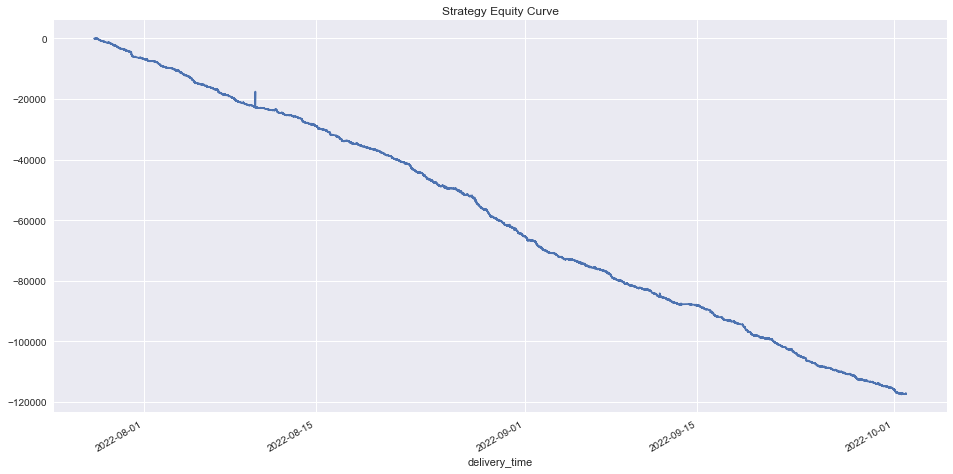

In [52]:
# Apply the algo to the whole dataset

deliveries = quotes.index

all_trading_sessions = []

for delivery_time in deliveries:
    
    trading_session = orderbook_imbalance_algo(delivery_time, phi_up = 0.8, phi_down = -0.8)
    all_trading_sessions.append(trading_session)
    
sess1 = pd.concat([all_trading_sessions[k] for k in range(len(all_trading_sessions))], axis=0)

sreturns = (sess1.traded_price - sess1.traded_price.shift(1)) * sess1.position.shift(1)

sev = StrategyEvaluator(data = sreturns, rounding = 2)
sev.print_performance()
sev.plot_performance()

<AxesSubplot:title={'center':'Strategy Equity Curve'}, xlabel='delivery_time'>

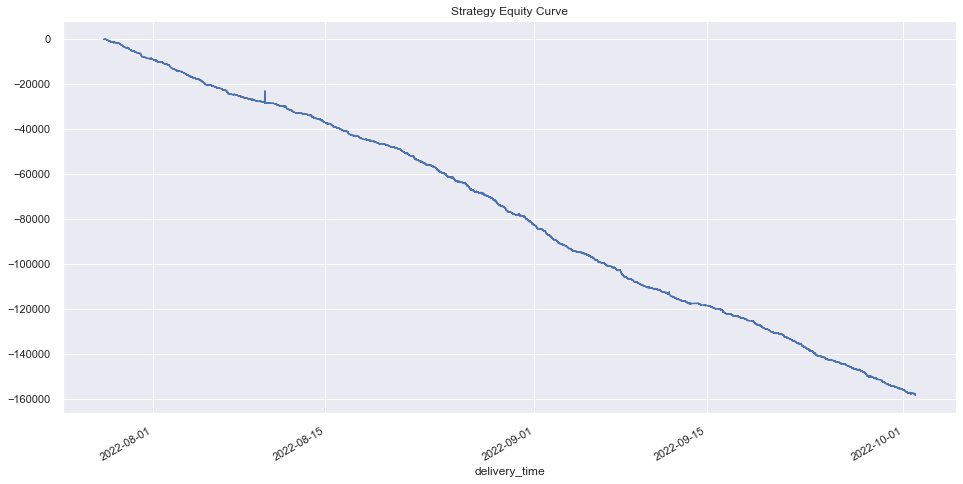

In [15]:
sev.plot_performance()

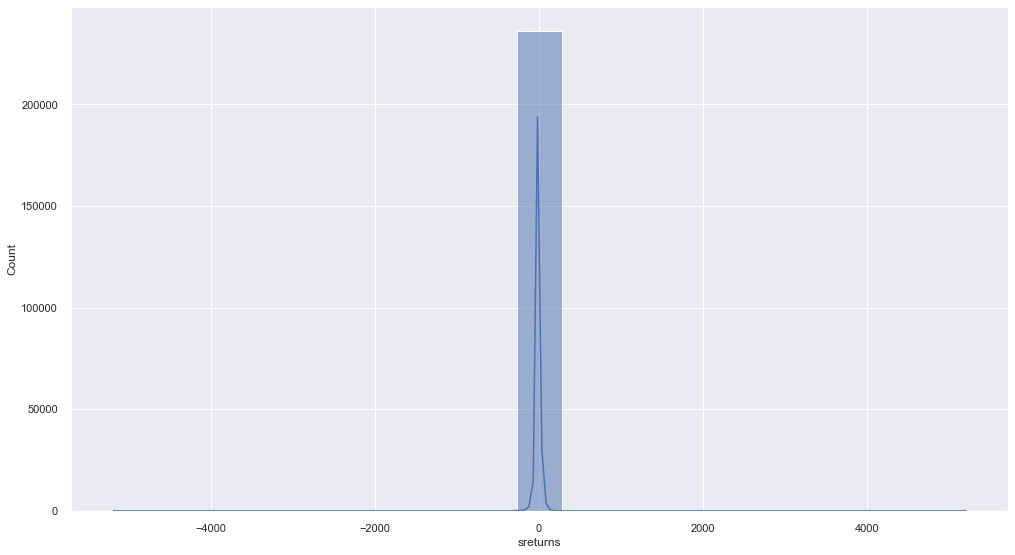

In [14]:
sev.plot_distribution()

## Conclusion


We can not extract value only from the order book, the market participant react and price fundamental data.

## Spread Scalper


The final algo we are going to construct is a spread scalper. This latter algo will react to previous regulation prices and NIV volumes. Namely, the trader assumes that the previous available values for the regulation prices and NIV volumes will persist also for the next settlement periods.

In [120]:
# data preparation

# Loading Data

df_wap_bal = pd.read_csv('strategy_data_lobniv.csv', index_col = 0, parse_dates=True)
raw_quotes = pd.read_pickle('outfile')
quotes = pd.DataFrame(raw_quotes)
quotes.columns = ['delivery_time', 'order_book']
quotes.set_index('delivery_time', drop=True, inplace=True)
quotes.loc['2022-07-28 00:00:00+00:00'].order_book.drop(columns = 'delivery_time', inplace=True)
df_wap_bal = df_wap_bal[['wap1', 'niv', 'imb']]
quotes['niv'] = df_wap_bal.niv
quotes['imb'] = df_wap_bal.imb
quotes['lag_niv'] = quotes.niv.shift(2)
quotes['lag_imb'] = quotes.imb.shift(2)
quotes.dropna(inplace=True)

In [119]:
quotes.head(20)

,order_book,niv,imb,lag_niv,lag_imb
delivery_time,,,,,
2022-07-28 00:00:00+00:00,bid_size bid ask ...,-120.34,201.000,NaN,NaN
2022-07-28 00:30:00+00:00,bid_size bid ask ...,-156.28,201.000,NaN,NaN
2022-07-28 01:00:00+00:00,bid_size bid ask ...,-78.31,201.500,-120.34,201.000
2022-07-28 01:30:00+00:00,bid_size bid ask ...,-97.40,201.300,-156.28,201.000
2022-07-28 02:00:00+00:00,bid_size bid ask ...,-160.25,201.100,-78.31,201.500
2022-07-28 02:30:00+00:00,bid_size bid ask ...,-145.55,201.600,-97.40,201.300
2022-07-28 03:00:00+00:00,bid_size bid ask ...,-173.98,201.600,-160.25,201.100
2022-07-28 03:30:00+00:00,bid_size bid ask ...,8.35,279.000,-145.55,201.600
2022-07-28 04:00:00+00:00,bid_size bid ask ...,112.77,297.000,-173.98,201.600


In [146]:
def spread_scalper_algo(delivery_time, premium = 10):
    
    order_book = quotes.loc[delivery_time].order_book.dropna()
    lagged_niv = quotes.loc[delivery_time].lag_niv.item()
    lagged_imb = quotes.loc[delivery_time].lag_imb.item()
    
    
    in_position = False 

    transaction_history = {'delivery_time': [], 'timestamp': [], 'traded_price': [], 'position': []} 
    position = 0
    
    if lagged_niv > 0:    # The trader assumes that the trend of the niv persists, so it considers one 
                      # hour lag
    
        
        for level in range(len(order_book)):

            if not in_position:

                store_trade, traded_price, position, in_position = buy_best_ask(order_book, level)
                position = 1
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(position)



            elif (in_position) & (traded_price > order_book.bid.iloc[level] + premium):
                store_trade, traded_price, position, in_position = sell_best_bid(order_book, level)
                position = -1
                in_position = False
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(position)



            elif (is_closing_time(delivery_time, order_book.index[level], time_to_delivery=16.)): # if there is no time left

                if position != 0:

                    if is_good_bet(position, traded_price, lagged_imb): # decides if could go to balance
                        position = position
                        break

                    else:
                        # If there is no premium in the balance then liquidate all positions in the market
                        # before delivery time.

                        store_trade, traded_price, position, in_position= close_position(order_book, position, level = level, size=1)
                        position = 0
                        transaction_history['delivery_time'].append(delivery_time)
                        transaction_history['timestamp'].append(order_book.index[store_trade])
                        transaction_history['traded_price'].append(traded_price)
                        transaction_history['position'].append(position)
                        break
                        
                        
    elif lagged_niv < 0:
            
        for level in range(len(order_book)):

            if not in_position:

                store_trade, traded_price, position, in_position = sell_best_bid(order_book, level)
                position = -1
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(position)



            elif (in_position) & (traded_price < order_book.ask.iloc[level] - premium):
                store_trade, traded_price, position, in_position = buy_best_ask(order_book, level)
                position = 1
                in_position = False
                transaction_history['delivery_time'].append(delivery_time)
                transaction_history['timestamp'].append(order_book.index[store_trade])
                transaction_history['traded_price'].append(traded_price)
                transaction_history['position'].append(position)



            elif (is_closing_time(delivery_time, order_book.index[level], time_to_delivery=16.)): # if there is no time left

                if position != 0:

                    if is_good_bet(position, traded_price, lagged_imb): # decides if could go to balance
                        position = position
                        break

                    else:
                        # If there is no premium in the balance then liquidate all positions in the market
                        # before delivery time.

                        store_trade, traded_price, position, in_position= close_position(order_book, position, level = level, size=1)
                        position = 0
                        transaction_history['delivery_time'].append(delivery_time)
                        transaction_history['timestamp'].append(order_book.index[store_trade])
                        transaction_history['traded_price'].append(traded_price)
                        transaction_history['position'].append(position)
                        break

            
            
            

    bkt = pd.DataFrame(transaction_history)
    bkt['returns'] = bkt.traded_price.shift(1) - bkt.traded_price
    if bkt.position.sum() != 0:
        bkt.iloc[-1, bkt.columns.get_loc('returns')] = float(quotes.loc[delivery_time].imb) - bkt.iloc[-1]['traded_price']

    bkt['sreturns'] = bkt.position.shift(1) * bkt.returns
    bkt.set_index('delivery_time', inplace=True)
    
    return bkt

Terminal Wealth: 7992.34


<AxesSubplot:title={'center':'Equity Curve episode: 2022-08-27 11:00:00+00:00'}, xlabel='timestamp'>

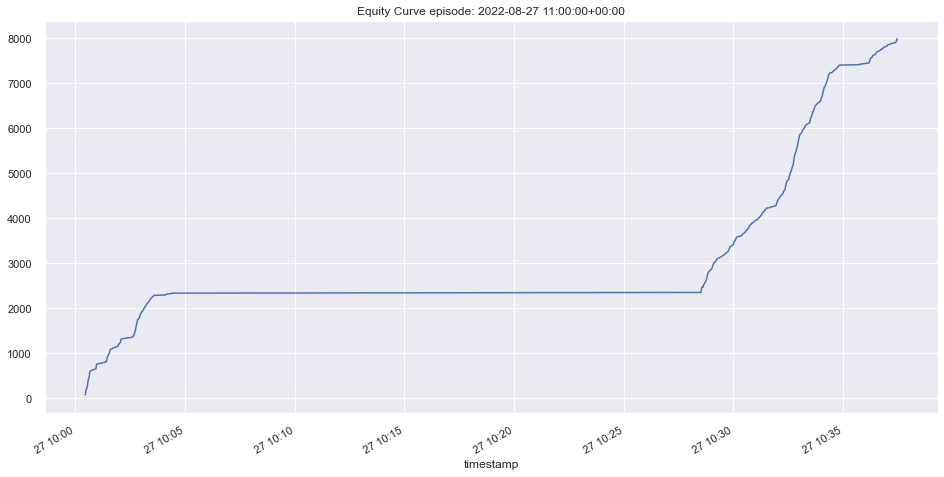

In [165]:
delivery_time = np.random.choice(deliveries) 


trial = spread_scalper_algo(delivery_time, premium=10)
sreturns = trial.sreturns
term = sreturns.sum()
print('Terminal Wealth: {:.2f}'.format(term))
trial.set_index('timestamp').sreturns.cumsum().plot(figsize=(16,8), title = f'Equity Curve episode: {delivery_time}') 

In [145]:
trial.sreturns.cumsum().plot(figsize=(16,8), title = f'Equity Curved episode: {delivery_time}' 

,timestamp,traded_price,position,returns,sreturns
delivery_time,,,,,
2022-09-06 08:30:00+00:00,2022-09-06 07:30:01,263.00,-1,NaN,NaN
2022-09-06 08:30:00+00:00,2022-09-06 07:30:04,273.90,1,-10.90,-10.90
2022-09-06 08:30:00+00:00,2022-09-06 07:30:05,263.00,-1,10.90,-10.90
2022-09-06 08:30:00+00:00,2022-09-06 07:30:21,274.90,1,-11.90,-11.90
2022-09-06 08:30:00+00:00,2022-09-06 07:30:24,263.00,-1,11.90,-11.90
...,...,...,...,...,...
2022-09-06 08:30:00+00:00,2022-09-06 07:37:26,280.52,-1,11.33,-11.33
2022-09-06 08:30:00+00:00,2022-09-06 07:37:47,294.90,1,-14.38,-14.38
2022-09-06 08:30:00+00:00,2022-09-06 07:37:48,283.61,-1,11.29,-11.29


In [1]:
len(deliveries)

NameError: name 'deliveries' is not defined

PERFORMANCE METRICS
Terminal Wealth: 19761808.25
--------------------------------------------------------------------------------
Sharpe Ratio: 1.12
--------------------------------------------------------------------------------
Sortino Ratio: 0.5
--------------------------------------------------------------------------------
Hit Rate: 0.99
--------------------------------------------------------------------------------
# Trades: 664218 | Wins: 658414.0 | Losses: 5804.0
--------------------------------------------------------------------------------
Average Return: 29.89
--------------------------------------------------------------------------------
Median Return: 23.42
--------------------------------------------------------------------------------
Standard Deviation of Returns: 26.79
--------------------------------------------------------------------------------
HHI: 0.0 | HHI plus: 0.0 | HHI minus: 0.0
-----------------------------------------------------------------------------

<AxesSubplot:title={'center':'Strategy Equity Curve'}, xlabel='delivery_time'>

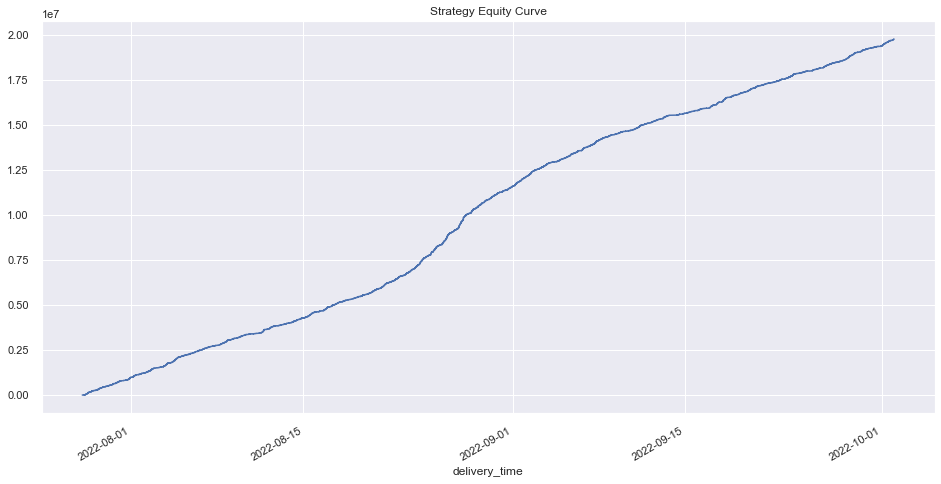

In [164]:
# Apply the algo to the whole dataset

deliveries = quotes.index

all_trading_sessions = []

for delivery_time in deliveries:
    
    trading_session = spread_scalper_algo(delivery_time, premium=10)
    all_trading_sessions.append(trading_session)
    
sess1 = pd.concat([all_trading_sessions[k] for k in range(len(all_trading_sessions))], axis=0)

sreturns = sess1.sreturns

sev = StrategyEvaluator(data = sreturns, rounding = 2)
sev.print_performance()
sev.plot_performance()

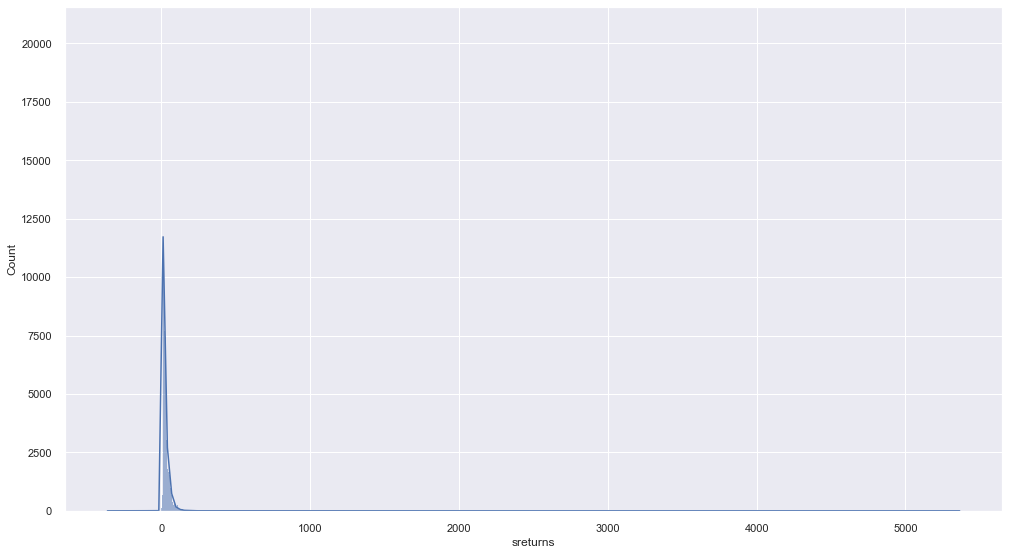

In [103]:
sev.plot_distribution()

# Conclusion

There is more value implementing algorithm with exogenous data for the power market.

In [169]:
dates = pd.date_range(start = '2023-01-01', end= '2023-06-03', freq = 'D')

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-05-25', '2023-05-26', '2023-05-27', '2023-05-28',
               '2023-05-29', '2023-05-30', '2023-05-31', '2023-06-01',
               '2023-06-02', '2023-06-03'],
              dtype='datetime64[ns]', length=154, freq='D')

In [170]:
pd.Series(dates).groupby(da)

0     2023-01-01
1     2023-01-02
2     2023-01-03
3     2023-01-04
4     2023-01-05
         ...    
149   2023-05-30
150   2023-05-31
151   2023-06-01
152   2023-06-02
153   2023-06-03
Length: 154, dtype: datetime64[ns]

In [181]:
(dates[-1] - dates[0]).weeks

AttributeError: 'Timedelta' object has no attribute 'weeks'

In [182]:
2014-1978

36